In [2]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from astropy.table import Table
import os
from os import listdir
import scipy as sc

In [3]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel/'
dirTrain = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/'
files = os.listdir(dirStars)
res = 4096
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R']

In [4]:
validPix = fitsio.read(dirTrain + 'Valid_'+str(res)+'_Pixels.fits')['PIXEL']

In [5]:
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

In [5]:
PIX = []
FOREGROUND = []
BADREGIONS = []
FOOTPRINT = []
CLASS = []

for file in files:
    starData = fitsio.read(dirStars + file, columns = usedCols)
    FOREGROUND = starData[usedCols[1]]
    BADREGIONS = starData[usedCols[2]]
    FOOTPRINT = starData[usedCols[3]]
    CLASS = starData[usedCols[4]]
    GMAG = starData[usedCols[5]]
    RMAG = starData[usedCols[6]]
    
    blueCut = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (CLASS <= 1) & 
                      (CLASS >= 0) &
                      (GMAG >= 23) &
                      # (GMAG >= 22) &
                      ((GMAG - RMAG) <= 1) &
                      ((GMAG - RMAG) >= -0.3))[0]
    
    theta, phi = hp.pix2ang(4096, starData[usedCols[0]][blueCut], nest = True, lonlat = True)
     
    allPIX = hp.ang2pix(res, theta, phi, nest = True, lonlat = True)
    
    trimPIX = allPIX[np.where(pixCheck[allPIX])[0]]
    
    PIX.extend(trimPIX)
    
PIX = np.array(PIX)

In [6]:
PIX = np.array(PIX)

# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPIXRepeats = PIX

# This sorts by the pixel in order to make following methods more efficient.
sortInds = starPIXRepeats.argsort()
starPIXRepeats = starPIXRepeats[sortInds[::1]]
starDETRepeats = np.zeros(len(starPIXRepeats))

# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
starPIX = np.unique(starPIXRepeats) # The unique pixels, with no repeats.
starDET = np.zeros_like(starPIX)

while starInd < len(starPIXRepeats):
    if starPIX[uniqInd] == starPIXRepeats[starInd]: # If the pixels match up in the arrays.
        starDET[uniqInd] += 1                # Add one for the detection..
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

In [7]:
corrections = fitsio.read(dirTrain + 'Inter_Blue_Faint_Corrections_Map.fits')['SIGNAL']

In [8]:
corrPerPix = np.full(12*(res**2), -1000.0)
corrPerPix[validPix] = corrections

In [9]:
origStarDET = starDET
starDET = starDET * corrPerPix[starPIX]

In [10]:
cropExtrMaps = fitsio.read(dirTrain + 'Extrapolation_Blue_Faint_Maps.fits')
inds = np.loadtxt(dirTrain + 'Inter_Blue_Faint_Indices.csv', delimiter = ',').astype(int)

In [11]:
allCropExtrMaps = np.zeros(len(cropExtrMaps[str(inds[0])]))
for ind in inds:
    allCropExtrMaps += cropExtrMaps[str(ind)]

In [12]:
extrMap = np.full(12*(res**2), hp.UNSEEN)
extrMap[validPix] = allCropExtrMaps

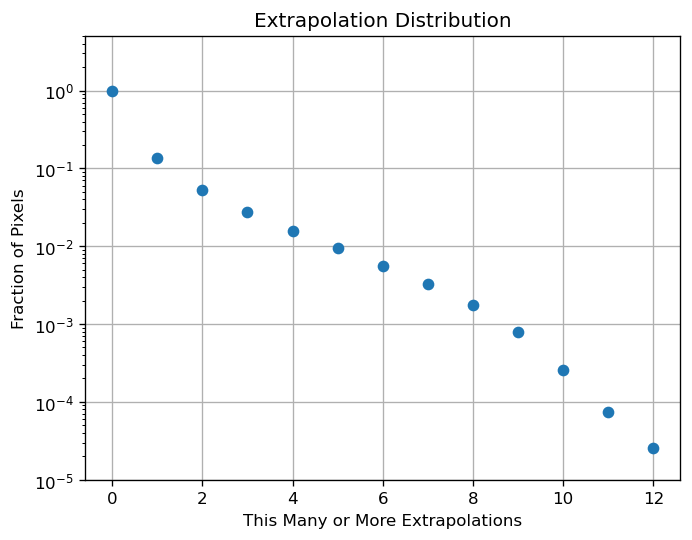

In [13]:
x = np.arange(13)
y = []
for xi in x:
    y.append(len(np.where(allCropExtrMaps >= xi)[0]) / len(allCropExtrMaps))
plt.figure(dpi = 120)
plt.scatter(x, y, zorder = 4)
plt.grid(zorder = 0)
plt.ylim([0.00001, 5])
plt.yscale('log')
plt.ylabel('Fraction of Pixels')
plt.xlabel('This Many or More Extrapolations')
plt.title('Extrapolation Distribution')
plt.show()

In [14]:
extrHsp = hsp.HealSparseMap(nside_coverage=32, healpix_map=extrMap)

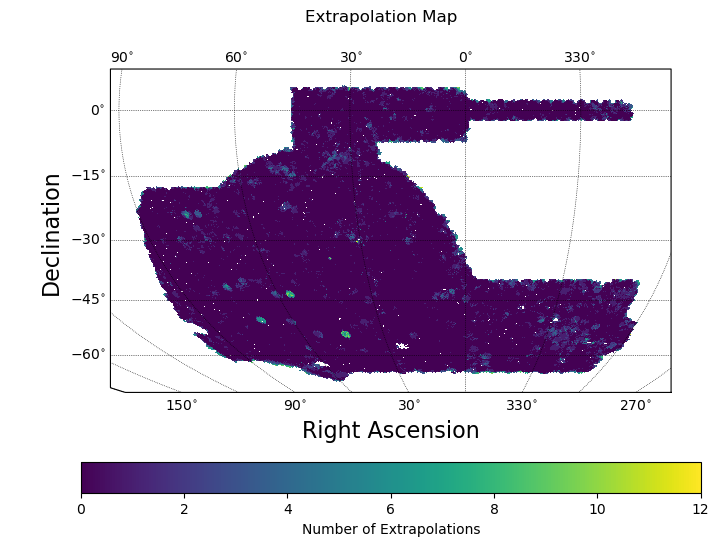

In [15]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(extrHsp, cmap = 'viridis')
plt.clim(0, 12)
plt.colorbar(location = 'bottom', label = 'Number of Extrapolations')
fig.suptitle('Extrapolation Map')
plt.show()

In [16]:
origFullMap = np.full(12*(res**2), hp.UNSEEN)
origFullMap[validPix] = 0
origFullMap[starPIX] = origStarDET
origFullMap[np.where(extrMap > 3)[0]] = hp.UNSEEN

In [17]:
fullMap = np.full(12*(res**2), hp.UNSEEN)
fullMap[validPix] = 0
fullMap[starPIX] = starDET
fullMap[np.where(extrMap > 3)[0]] = hp.UNSEEN

In [18]:
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

In [19]:
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, 512, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [20]:
map512 = np.full(12*(res**2), 0.0)
map512[fracPix] = fullMap[fracPix] / fracMap[fracPix]
map512[np.where(map512 <= 0)[0]] = hp.UNSEEN

In [21]:
origMap512 = np.full(12*(res**2), 0.0)
origMap512[fracPix] = origFullMap[fracPix] / fracMap[fracPix]
origMap512[np.where(origMap512 <= 0)[0]] = hp.UNSEEN

In [22]:
weights = np.full(12*(res**2), 0.0)
weights[np.where(map512 >= 0)[0]] = 1.0

In [23]:
nside_coverage = 32
hspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=map512)
origHspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origMap512)

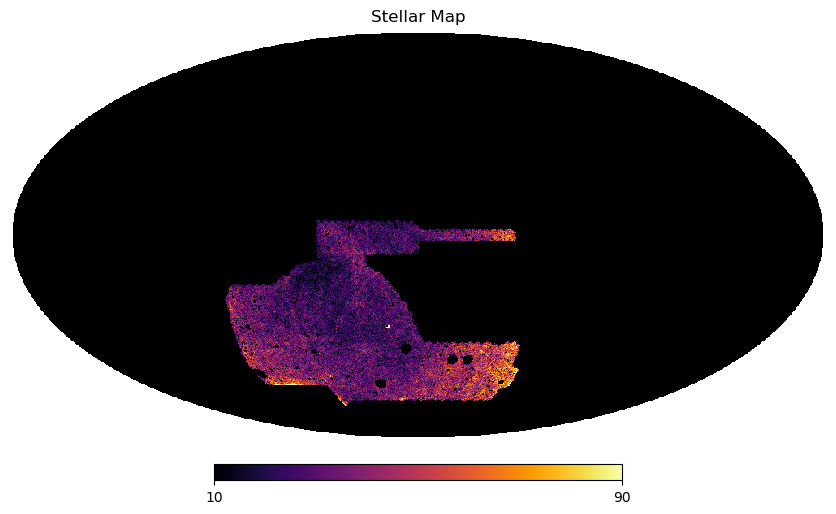

In [24]:
hp.mollview(map512, nest=True, title="Stellar Map", min = 10, max = 90, badcolor = 'black', cmap = 'inferno', xsize = 1000)

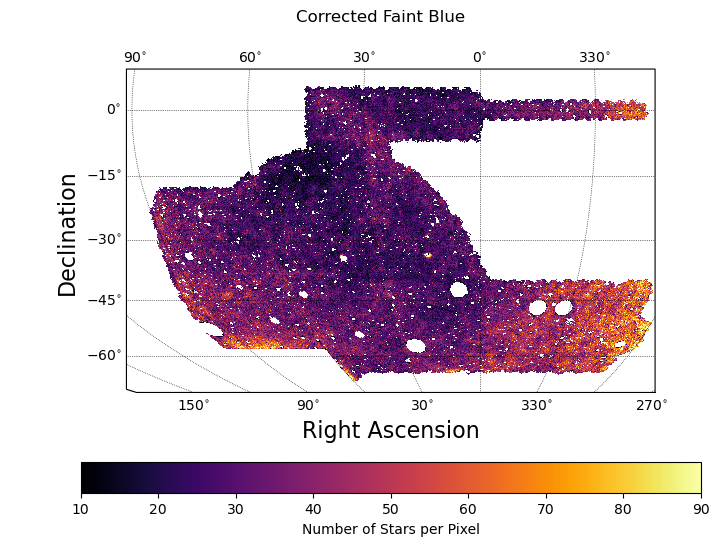

In [25]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspMap512, cmap = 'inferno')
plt.clim(10, 90)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Faint Blue')
plt.show()

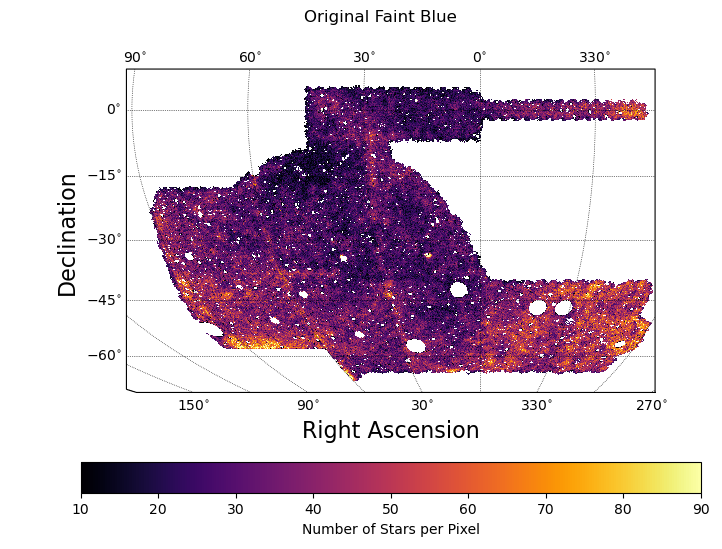

In [26]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(origHspMap512, cmap = 'inferno')
plt.clim(10, 90)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Faint Blue')
plt.show()

In [27]:
degrees = 5
sig = degrees * np.pi / 180

In [28]:
smoothWeights = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(weights, n2r = True), sigma = sig), r2n = True)
smoothMap = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(map512, n2r = True), sigma = sig), r2n = True)
origSmoothMap = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(origMap512, n2r = True), sigma = sig), r2n = True)

smoothMap[np.where(weights == 1)[0]] = smoothMap[np.where(weights == 1)[0]] / smoothWeights[np.where(weights == 1)[0]]
origSmoothMap[np.where(weights == 1)[0]] = origSmoothMap[np.where(weights == 1)[0]] / smoothWeights[np.where(weights == 1)[0]]

smoothMap[np.where(weights == 0)[0]] = hp.UNSEEN
origSmoothMap[np.where(weights == 0)[0]] = hp.UNSEEN

In [29]:
hspSmoothMap = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=smoothMap)
origHspSmoothMap = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origSmoothMap)

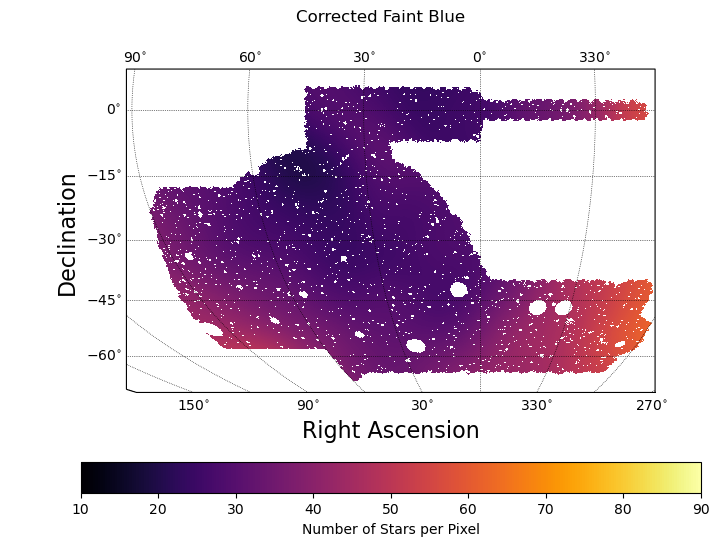

In [30]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspSmoothMap, cmap = 'inferno')
plt.clim(10, 90)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Faint Blue')
plt.show()

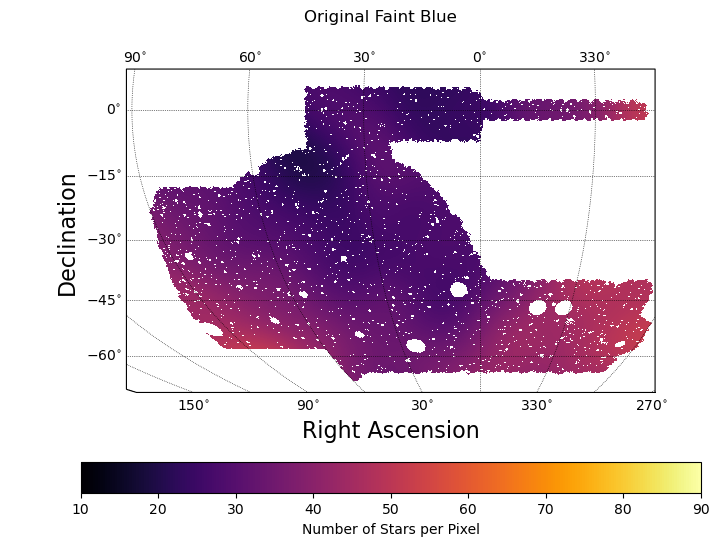

In [31]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(origHspSmoothMap, cmap = 'inferno')
plt.clim(10, 90)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Faint Blue')
plt.show()

In [32]:
adjCorr = map512 - smoothMap
adjCorr[np.where(weights == 0)[0]] = hp.UNSEEN

adjOrig = origMap512 - origSmoothMap
adjOrig[np.where(weights == 0)[0]] = hp.UNSEEN

hspAdjCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=adjCorr)
hspAdjOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=adjOrig)

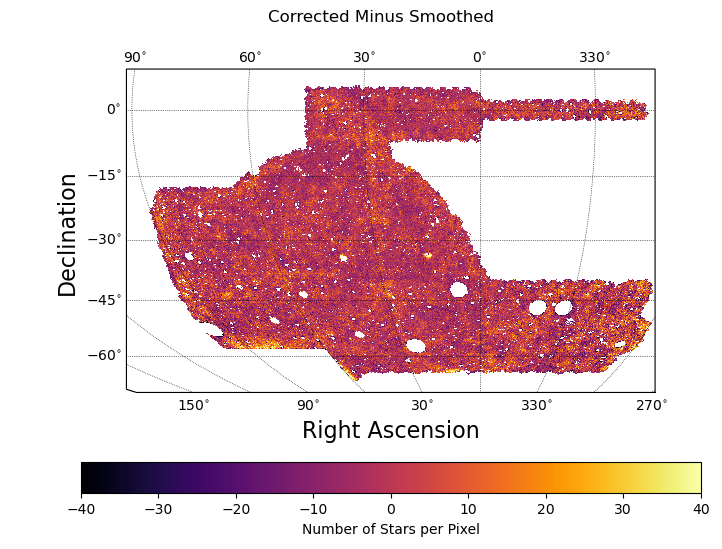

In [38]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspAdjCorr, cmap = 'inferno')
plt.clim(-40, 40)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Minus Smoothed')
plt.show()

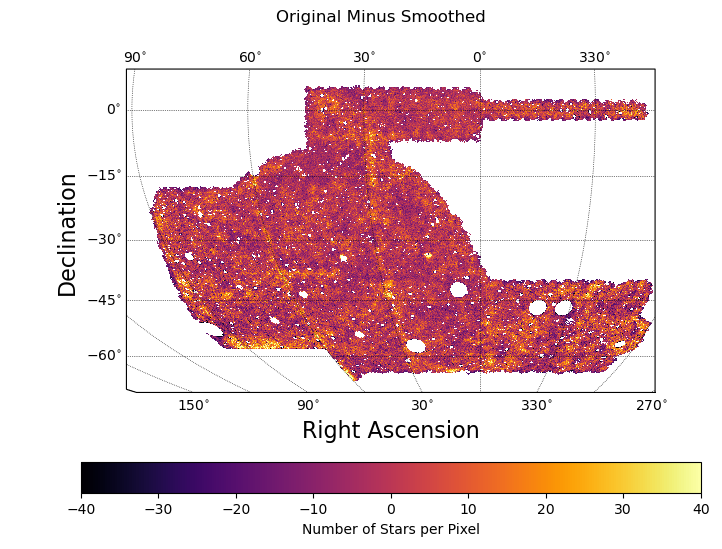

In [39]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspAdjOrig, cmap = 'inferno')
plt.clim(-40, 40)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Minus Smoothed')
plt.show()

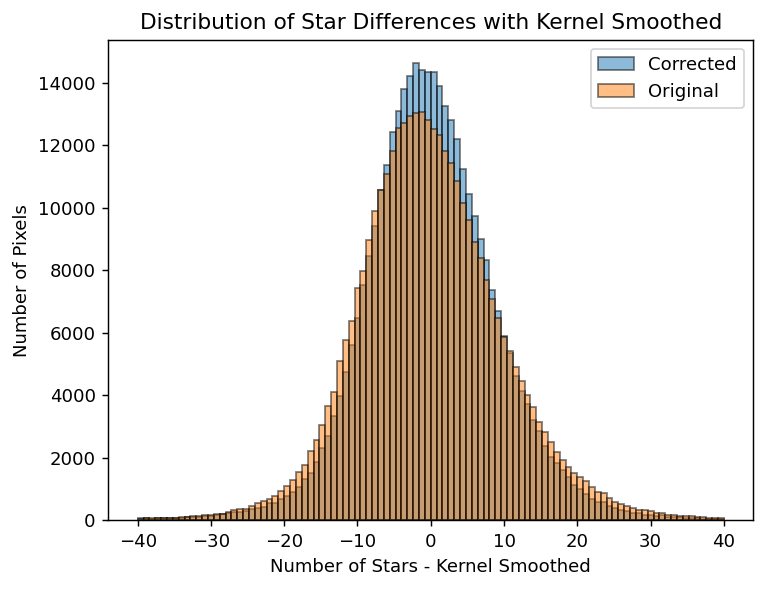

In [33]:
plt.figure(dpi = 130)
plt.hist(hspAdjCorr[hspAdjCorr.valid_pixels], bins = np.linspace(-40, 40, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Corrected')
plt.hist(hspAdjOrig[hspAdjOrig.valid_pixels], bins = np.linspace(-40, 40, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Original')
plt.legend()
plt.title('Distribution of Star Differences with Kernel Smoothed')
plt.xlabel('Number of Stars - Kernel Smoothed')
plt.ylabel('Number of Pixels')
plt.show()

In [37]:
print(sc.stats.tstd(hspAdjCorr[hspAdjCorr.valid_pixels]))
print(sc.stats.tstd(hspAdjOrig[hspAdjOrig.valid_pixels]))

9.81560950666539
10.61485855456197


In [40]:
print(sc.stats.skew(hspAdjCorr[hspAdjCorr.valid_pixels]))
print(sc.stats.skew(hspAdjOrig[hspAdjOrig.valid_pixels]))

7.867484979340196
4.808910323514081


In [41]:
print(sc.stats.kurtosis(hspAdjCorr[hspAdjCorr.valid_pixels]))
print(sc.stats.kurtosis(hspAdjOrig[hspAdjOrig.valid_pixels]))

567.0316240734574
265.0085357943685
